In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
) 
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random

In [6]:
!nvidia-smi

Tue Dec 31 00:32:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:25:00.0 Off |                    0 |
| N/A   41C    P0             77W /  500W |   45029MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache) 

pad_token_id = model.tokenizer.pad_token_id
for param in model.parameters():
   param.requires_grad_(False)

Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [4]:
device = "cuda"
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

In [5]:
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()

def clear_memory():
   for sae in saes:
      for param in sae.parameters():
         param.grad = None
      for param in sae.mask.parameters():
         param.grad = None

   for param in model.parameters():
      param.grad = None
   cleanup_cuda()


In [7]:
class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points  # list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation is not None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def print_mask_statistics(self):
        """
        Prints statistics about each binary mask:
          - total number of elements (latents)
          - total number of 'on' latents (mask == 1)
          - average on-latents per token
            * If shape == [latent_dim], there's effectively 1 token
            * If shape == [seq, latent_dim], it's 'sum of on-latents / seq'
        """
        for i, mask in enumerate(self.masks):
            shape = list(mask.shape)
            total_latents = mask.numel()
            total_on = mask.sum().item()  # number of 1's in the mask

            # Average on-latents per token depends on dimensions
            if len(shape) == 1:
                # e.g., shape == [latent_dim]
                avg_on_per_token = total_on  # only one token
            elif len(shape) == 2:
                # e.g., shape == [seq, latent_dim]
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0
            else:
                # If there's more than 2 dims, adapt as needed;
                # we'll just define "token" as the first dimension.
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0

            print(f"Statistics for mask '{self.hook_points[i]}':")
            print(f"  - Shape: {shape}")
            print(f"  - Total latents: {total_latents}")
            print(f"  - Latents ON (mask=1): {int(total_on)}")
            print(f"  - Average ON per token: {avg_on_per_token:.4f}\n")

    def save(self, save_dir, file_name="sae_masks.pt"):
        """
        Saves hook_points and masks to a single file (file_name) within save_dir.
        If you want multiple mask sets in the same directory, call save() with
        different file_name values. The directory is created if it does not exist.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        save_path = os.path.join(save_dir, file_name)
        checkpoint = {
            "hook_points": self.hook_points,
            "masks": self.masks
        }
        torch.save(checkpoint, save_path)
        print(f"SAEMasks saved to {save_path}")

    @classmethod
    def load(cls, load_dir, file_name="sae_masks.pt"):
        """
        Loads hook_points and masks from a single file (file_name) within load_dir,
        returning an instance of SAEMasks. If you stored multiple mask sets in the
        directory, specify the file_name to load the correct one.
        """
        load_path = os.path.join(load_dir, file_name)
        if not os.path.isfile(load_path):
            raise FileNotFoundError(f"No saved SAEMasks found at {load_path}")

        checkpoint = torch.load(load_path)
        hook_points = checkpoint["hook_points"]
        masks = checkpoint["masks"]

        instance = cls(hook_points=hook_points, masks=masks)
        print(f"SAEMasks loaded from {load_path}")
        return instance
    def get_num_latents(self):
        num_latents = 0
        for mask in self.masks:
            num_latents += (mask>0).sum().item()
        return num_latents


In [8]:
class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        # mask = self.mask
        self.sparsity_loss = torch.abs(mask).sum() * self.l1
        # print("hello", torch.abs(mask).sum()) 
        # if len(mask.shape) == 2:
        #     self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.distinct_l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation

# for sae in saes:
#     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)

In [9]:
class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}
    
    def get_binarized_mask(self, threshold):
        return (self.ig_scores.abs()>threshold).float()
    
def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()



def produce_ig_binary_masks(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        hook_points.append(hook_point)
        masks.append(mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

In [10]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,
    
    # Masking options
    circuit_mask: Optional[SAEMasks] = None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    
    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    
    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

                
        if circuit_mask is not None:
            hook_point = sae.cfg.hook_name
            if mean_mask==True:
                feature_acts = circuit_mask(feature_acts, hook_point, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = circuit_mask(feature_acts, hook_point)
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook


    # def sae_hook_ablate(value, hook):
    # feature_acts = sae.encode(value)
    # # feature_acts[:, :, topsae_attr_indices] = 0
    # out = sae.decode(feature_acts)
    # return out


def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    # blocks.0.hook_resid_pre
    # # fake hook that adds zero so gradients propagate through the model
    # param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    # hooks.append(
    #     (
    #         "blocks.0.hook_resid_pre",
    #         lambda value, hook: value + param,
    #     )
    # )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

# data

In [11]:
import json
file_path = 'data/ioi/ioi_train.json'
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]
for entry in data:
    print(entry)
    break
# example_length = 7

{'clean_prefix': 'Then, Richard and Erica went to the hospital. Richard gave a drink to', 'patch_prefix': 'Then, Matthew and Crystal went to the hospital. Megan gave a drink to', 'clean_answer': ' Erica', 'patch_answer': ' Richard', 'case': 'BABA_16'}


In [12]:
file_path = 'data/ioi/ioi_train_21.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [13]:
from transformer_lens.utils import test_prompt
test_prompt("Then, Matthew and Crystal went to the hospital. Megan gave a drink to", " Erica", model)

Tokenized prompt: ['<bos>', 'Then', ',', ' Matthew', ' and', ' Crystal', ' went', ' to', ' the', ' hospital', '.', ' Megan', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 667      Logit: 17.49 Prob:  0.00% Token: | Erica|

Top 0th token. Logit: 28.58 Prob: 43.22% Token: | Matthew|
Top 1th token. Logit: 27.45 Prob: 13.99% Token: | Crystal|
Top 2th token. Logit: 27.27 Prob: 11.63% Token: | her|
Top 3th token. Logit: 27.19 Prob: 10.73% Token: | the|
Top 4th token. Logit: 26.28 Prob:  4.33% Token: | them|
Top 5th token. Logit: 25.45 Prob:  1.88% Token: | both|
Top 6th token. Logit: 25.22 Prob:  1.50% Token: | him|
Top 7th token. Logit: 25.16 Prob:  1.41% Token: | a|
Top 8th token. Logit: 25.14 Prob:  1.39% Token: | each|
Top 9th token. Logit: 24.26 Prob:  0.57% Token: | Matt|


Ranks of the answer tokens: [(' Erica', 667)]

In [14]:
example_length = 20

In [15]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    if model.to_tokens(entry['clean_prefix']).shape[-1] == example_length:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])
print(len(clean_data))

2966


In [16]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    if model.to_tokens(entry['clean_prefix']).shape[-1] == example_length:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])

N = 2900
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

batch_size = 16 
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)

torch.Size([2900, 20]) torch.Size([2900, 20])
torch.Size([181, 16, 20]) torch.Size([181, 16, 20]) torch.Size([181, 16]) torch.Size([181, 16])


In [17]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
avg_logit_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_logit_diff)

tensor(4.3811, device='cuda:0')
tensor(4.2698, device='cuda:0')
tensor(4.0039, device='cuda:0')
tensor(3.3653, device='cuda:0')
tensor(3.4589, device='cuda:0')
tensor(3.2856, device='cuda:0')
tensor(3.1497, device='cuda:0')
tensor(3.6056, device='cuda:0')
tensor(3.6865, device='cuda:0')
tensor(3.4956, device='cuda:0')
Average LD:  3.6701977252960205


In [18]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

In [19]:
def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j], 
                        return_type="logits", 
                        fwd_hooks=build_hooks_list(mean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 25, 16)

Mean Accum Progress: 100%|██████████| 400/400 [01:40<00:00,  3.99it/s]


In [20]:
use_mask

False

In [17]:
saes[0].mean_ablation.shape

torch.Size([1, 20, 16384])

In [21]:
avg_mean_diff = 0
with torch.no_grad():
    for i in range(5):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], mean_ablate=True)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_mean_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_mean_diff)

tensor(0.1156, device='cuda:0')
tensor(-0.1215, device='cuda:0')
tensor(-0.1009, device='cuda:0')
tensor(-0.1535, device='cuda:0')
tensor(-0.0856, device='cuda:0')
Average LD:  tensor(-0.3460, device='cuda:0')


# mask training 

In [22]:
import torch.nn.functional as F
import wandb

In [23]:
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

In [24]:
avg_logit_diff

3.6701977252960205

In [25]:
def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, task, example_length=6, loss_function='ce', per_token_mask=False, use_mask=True, mean_mask=False, distinct_sparsity_multiplier=0 ):

    def logitfn(tokens, use_mask, mean_mask):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, clean_label_tokens, corr_label_tokens, logitfn, ratio_trained=1, loss_function='ce'):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens, use_mask, mean_mask)
        model_logits = logitfn(tokens, False, False)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce':
            loss = F.cross_entropy(last_token_logits, clean_label_tokens)
        elif loss_function == 'logit_diff':
            fwd_logit_diff = logit_diff_fn(logits, clean_label_tokens, corr_label_tokens)
            model_logit_diff = logit_diff_fn(model_logits, clean_label_tokens, corr_label_tokens)
            loss = torch.abs(model_logit_diff - fwd_logit_diff)
        
        del model_logits, logits
        cleanup_cuda()

        sparsity_loss = 0
        distinct_sparsity_loss = 0
        # if per_token_mask:
        #     distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            # if per_token_mask:
            #     distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 1,
        "total_steps": token_dataset.shape[0]*0.8,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*20 #*config["batch_size"]
    # epochs = 20
    with tqdm(total=total_steps*1.1, desc="Training Progress") as pbar:
        # for epoch in range(epochs):
        for i, (x, y, z) in enumerate(zip(token_dataset, labels_dataset, corr_labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained =  i / total_steps*1.1
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, _ = forward_pass(x, y, z, logitfn, ratio_trained=ratio_trained, loss_function=loss_function)
                # if per_token_mask:
                #     sparsity_loss = sparsity_loss / example_length
                # print("sp loss", sparsity_loss)
                # print("sae 0 sp loss", saes[0].mask.sparsity_loss)
                # print("sae 1 sp loss", saes[1].mask.sparsity_loss)
                # print("sae 2 sp loss", saes[2].mask.sparsity_loss)
                # print("sae 3 sp loss", saes[3].mask.sparsity_loss)
                
                avg_nonzero_elements = sparsity_loss
                # avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] #+ distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = sparsity_loss + loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature} # "avg distinct lat/sae":avg_distinct_nonzero_elements.item()
                wandb.log(infodict)
                # break
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                # break
                if i >= total_steps*1.1:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss
    
    def eval_logit_diff(num_batches, batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        avg_ld = 0
        for i in range(num_batches):
            tokens = batch[-i]
            logits = logitfn(tokens)
            ld = logit_diff_fn(logits, clean_labels[-i], corr_labels[-i])
            avg_ld += ld
            del logits
            cleanup_cuda()
        return (avg_ld / num_batches).item()

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(10, token_dataset, labels_dataset, corr_labels_dataset, masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()
    
    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[0].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    save_path = f"masks/{task}/{loss_function}_{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff
    faithfulness = logit_diff / avg_logit_diff
    mask_dict['faithfulness'] = faithfulness
    
    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [46]:
do_training_run(token_dataset =clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=0.001, task='ioi/baba21/', example_length=20, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 0.001


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.73s/it, Step=144, Progress=1.09, Avg Nonzero Elements=424, Task Loss=0.99, Sparsity Loss=0.424, temperature=tensor(328.9644)]   /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.74s/it, Step=160, Progress=1.22, Avg Nonzero Elements=424, Task Loss=0.576, Sparsity Loss=0.424, temperature=tensor(626.3716)]                          


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,█▂▄▃▄▃▁▂▃▅▂▂▃▂▃▃▂▅▂▄▂▂▂▅▁▃▅▂▄▂▁▂▁▁▃▃▃▄▂▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,423.75
Progress,1.21547
Sparsity Loss,0.42375
Step,160
Task Loss,0.5762


CE loss: tensor(6.7493, device='cuda:0')
Logit Diff: 3.4706146717071533
total # latents in circuit:  1695
avg density 423.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


## sweep

In [26]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.0001
end_threshold = 0.07
n_runs = 10
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.0001,
 0.0008169486447931527,
 0.0029279087018544933,
 0.006432880171184024,
 0.01133186305278174,
 0.017624857346647652,
 0.025311863052781748,
 0.03439288017118403,
 0.044867908701854496,
 0.05673694864479317]

## actual sweep

In [56]:
for i in thresholds:
    do_training_run(token_dataset=clean_tokens, labels_dataset=clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=i, task='ioi/baba21/', example_length=20, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 0.0001


Avg Nonzero Elements,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,█▃▂▂▂▁▂▂▁▂▂▁▂▁▁▃▃▂▃▂▂▂▁▃▂▁▁▁▂▂▂▂▂▂▁▂▂▁▂▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▇▇█
Avg Nonzero Elements,1939.0
Progress,0.63812
Sparsity Loss,0.09695
Step,84
Task Loss,0.38757


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.73s/it, Step=144, Progress=1.09, Avg Nonzero Elements=1.5e+3, Task Loss=0.344, Sparsity Loss=0.15, temperature=tensor(328.9644)]  /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.73s/it, Step=160, Progress=1.22, Avg Nonzero Elements=1.5e+3, Task Loss=0.259, Sparsity Loss=0.15, temperature=tensor(626.3716)]                           


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,█▄▂▂▂▃▂▃▁▆▁▂▃▂▂▂▂▄▂▃▃▂▁▄▁▄▄▃▂▃▂▁▃▂▄▂▃▂▂▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,1496.75
Progress,1.21547
Sparsity Loss,0.14967
Step,160
Task Loss,0.25914


CE loss: tensor(6.7329, device='cuda:0')
Logit Diff: 3.714040756225586
total # latents in circuit:  5987
avg density 1496.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.0008169486447931527


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.73s/it, Step=144, Progress=1.09, Avg Nonzero Elements=482, Task Loss=1.09, Sparsity Loss=0.394, temperature=tensor(328.9644)]   /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.73s/it, Step=160, Progress=1.22, Avg Nonzero Elements=482, Task Loss=0.601, Sparsity Loss=0.394, temperature=tensor(626.3716)]                          


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,█▂▄▃▄▃▁▂▂▅▁▁▃▂▃▃▂▅▂▄▂▂▂▅▁▄▅▂▃▂▁▂▁▁▃▃▃▃▂▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,481.75
Progress,1.21547
Sparsity Loss,0.39356
Step,160
Task Loss,0.60055


CE loss: tensor(6.7058, device='cuda:0')
Logit Diff: 3.480978012084961
total # latents in circuit:  1927
avg density 481.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.0029279087018544933


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.73s/it, Step=144, Progress=1.09, Avg Nonzero Elements=206, Task Loss=1.46, Sparsity Loss=0.602, temperature=tensor(328.9644)]   /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.73s/it, Step=160, Progress=1.22, Avg Nonzero Elements=206, Task Loss=0.694, Sparsity Loss=0.602, temperature=tensor(626.3716)]                          


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,█▂▅▄▄▅▁▁▃▆▃▄▂▃▄▄▁▅▃▄▁▃▃▅▂▄▅▁▄▂▁▂▂▂▃▃▄▅▃▄
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,205.5
Progress,1.21547
Sparsity Loss,0.60169
Step,160
Task Loss,0.69364


CE loss: tensor(6.9674, device='cuda:0')
Logit Diff: 3.2195041179656982
total # latents in circuit:  822
avg density 205.5
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.006432880171184024


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.74s/it, Step=144, Progress=1.09, Avg Nonzero Elements=81.8, Task Loss=2.55, Sparsity Loss=0.526, temperature=tensor(328.9644)] /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.73s/it, Step=160, Progress=1.22, Avg Nonzero Elements=81.8, Task Loss=2.56, Sparsity Loss=0.526, temperature=tensor(626.3716)]                           


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,█▁▇▅▅▇▂▄▅█▄▄▁▅▆▄▃▇▅▆▃▅▄█▄▄▆▄▇▄▄▄▃▄▆▅▆▆▅▆
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,81.75
Progress,1.21547
Sparsity Loss,0.52589
Step,160
Task Loss,2.56433


CE loss: tensor(7.5353, device='cuda:0')
Logit Diff: 1.6274921894073486
total # latents in circuit:  327
avg density 81.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.01133186305278174


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.74s/it, Step=144, Progress=1.09, Avg Nonzero Elements=37.5, Task Loss=2.93, Sparsity Loss=0.425, temperature=tensor(328.9644)] /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.74s/it, Step=160, Progress=1.22, Avg Nonzero Elements=37.5, Task Loss=3.04, Sparsity Loss=0.425, temperature=tensor(626.3716)]                           


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,▇▁▇▅▅▇▂▄▅█▃▄▁▅▅▄▃▇▄▆▂▅▅▇▃▄▅▄▇▄▄▄▃▄▇▄▆▆▄▆
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,37.5
Progress,1.21547
Sparsity Loss,0.42494
Step,160
Task Loss,3.04385


CE loss: tensor(7.8376, device='cuda:0')
Logit Diff: 1.0498268604278564
total # latents in circuit:  150
avg density 37.5
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.017624857346647652


Training Progress:  99%|█████████▉| 144/144.8 [04:11<00:01,  1.74s/it, Step=144, Progress=1.09, Avg Nonzero Elements=24, Task Loss=3.01, Sparsity Loss=0.423, temperature=tensor(328.9644)]   /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 161it [04:39,  1.74s/it, Step=160, Progress=1.22, Avg Nonzero Elements=24, Task Loss=3.1, Sparsity Loss=0.423, temperature=tensor(626.3716)]                            


Avg Nonzero Elements,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,▆▁▇▅▅▇▂▅▅█▃▄▁▆▅▄▃▇▄▆▂▅▅█▃▃▅▃▇▄▄▄▃▄█▄▆▆▄▆
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▆▆█
Avg Nonzero Elements,24.0
Progress,1.21547
Sparsity Loss,0.423
Step,160
Task Loss,3.09828


CE loss: tensor(7.7872, device='cuda:0')
Logit Diff: 0.9317105412483215
total # latents in circuit:  96
avg density 24.0
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.025311863052781748


Training Progress:  10%|▉         | 14/144.8 [00:24<03:49,  1.76s/it, Step=13, Progress=0.0988, Avg Nonzero Elements=18.9, Task Loss=3.38, Sparsity Loss=0.477, temperature=tensor(1.6875)]   


KeyboardInterrupt: 

## mask frontier

In [37]:
clean_tokens.shape[0]*0.5*1.1

99.55000000000001

In [29]:
thresholds[:6]

[0.0001,
 0.0008169486447931527,
 0.0029279087018544933,
 0.006432880171184024,
 0.01133186305278174,
 0.017624857346647652]

In [30]:
nnodes = []
faithfulness = []
for i in thresholds[:6]:
    sparsity_multiplier = i
    bdir = f"masks/ioi/baba21/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])
faithfulness

[1.0119456863665375,
 0.9484442726595069,
 0.8772018182497316,
 0.44343447171530326,
 0.2860409544674279,
 0.2538584051825639]

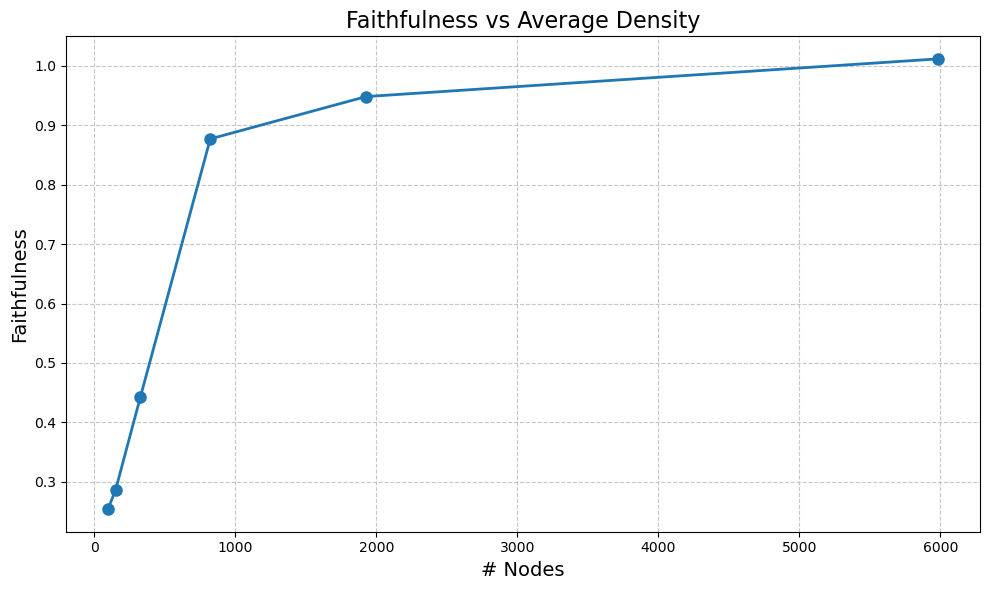

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Highlight data points
# for x, y in zip(nnodes, faithfulness):
#     plt.scatter(x, y, color='red', edgecolor='black', zorder=5)
#     plt.text(x, y + 0.02, f'({x:.2f}, {y:.2f})', fontsize=9, ha='center')

# Add labels and title
plt.xlabel("# Nodes", fontsize=14)
plt.ylabel("Faithfulness", fontsize=14)
plt.title("Faithfulness vs Average Density", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# IG

In [32]:
import torch.nn.functional as F
def get_ig_effect_batch(sae_id, token_dataset, corr_token_dataset, labels_dataset, corr_labels_dataset):
    # ig_batch_size = 4

    def logitfn_cache(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, cache_sae_activations=True)
            )
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations
    
    # cache_sae_logitfn = build_sae_logitfn(cache_sae_activations=True)

    # def cache_sae_activations(tokens):
    #     logits = cache_sae_logitfn(tokens)
    #     cached_activations = [sae.feature_acts for sae in saes]
    #     return logits, cached_activations
    # def build_sae_logitfn(**kwargs):
    # def logitfn(tokens):
    #     return model.run_with_hooks(
    #         tokens, 
    #         return_type="logits", 
    #         fwd_hooks=build_hooks_list(tokens, **kwargs)
    #         )
    # return logitfn

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logits = model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, fake_activations=(sae_idx, cache),**kwargs)
            )
        # logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logits

    # correct_tokenized = batch.correct_tokenized
    # traceback_tokenized = batch.error_tokenized
    # correct_labels = batch.correct_labels
    # traceback_labels = batch.error_labels

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, clean_activations = logitfn_cache(token_dataset)
        _, corr_activations = logitfn_cache(corr_token_dataset)


    sae = saes[sae_id]
    sae_clean_acts = clean_activations[sae_id]
    sae_corr_acts = corr_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            token_dataset, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        clean_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), labels_dataset]
        corr_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), corr_labels_dataset]
        metric = torch.sum(clean_logprobs - corr_logprobs)
        metric.backward()

        counterfactual_delta = sae_clean_acts - sae_corr_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)


In [33]:
def get_sae_ig_effect(sae_id, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    effect_batches = []
    for i in tqdm(range(0, num_batches)):
        clean_batch = clean_tokens[i]  
        corr_batch = corr_tokens[i]
        clean_label_batch = clean_label_tokens[i]
        corr_label_batch = corr_label_tokens[i]
        effect_batches.append(get_ig_effect_batch(sae_id, clean_batch, corr_batch, clean_label_batch, corr_label_batch))
    return torch.stack(effect_batches).mean(dim=0)

In [34]:
def get_all_sae_ig_effects(num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)
        saes[i].igmask = IGMask(ig_effect)
        

In [39]:
get_all_sae_ig_effects(25, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)

100%|██████████| 25/25 [03:40<00:00,  8.81s/it]


In [40]:
torch.count_nonzero(saes[1].igmask.ig_scores)

tensor(7271, device='cuda:0')

In [41]:
def save_igmask(igmask, file_path):
    """Save the IGMask instance to a file."""
    if not isinstance(igmask, IGMask):
        raise ValueError("The object to save must be an instance of IGMask.")

    # Save the ig_scores and any additional parameters if needed
    state_dict = {
        'ig_scores': igmask.ig_scores
    }
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the state dictionary using PyTorch
    torch.save(state_dict, file_path)

for sae in saes:
    save_igmask(sae.igmask, f"masks/ioi/baba21/igmask/igmask_{sae.cfg.hook_layer}.pt")

In [44]:
masks = produce_ig_binary_masks(threshold=0.01)

In [45]:
masks.print_mask_statistics()

Statistics for mask 'blocks.7.hook_resid_post':
  - Shape: [20, 16384]
  - Total latents: 327680
  - Latents ON (mask=1): 39
  - Average ON per token: 1.9500

Statistics for mask 'blocks.14.hook_resid_post':
  - Shape: [20, 16384]
  - Total latents: 327680
  - Latents ON (mask=1): 55
  - Average ON per token: 2.7500

Statistics for mask 'blocks.21.hook_resid_post':
  - Shape: [20, 16384]
  - Total latents: 327680
  - Latents ON (mask=1): 86
  - Average ON per token: 4.3000

Statistics for mask 'blocks.40.hook_resid_post':
  - Shape: [20, 16384]
  - Total latents: 327680
  - Latents ON (mask=1): 119
  - Average ON per token: 5.9500



In [46]:
def pp(x):
    keys = list(x.keys())
    values = list(x.values())
    for i in range(len(keys)):
        print(f"{keys[i]}: {values[i]}")

In [48]:
threshold = 0.001
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logits = model.run_with_hooks(
            clean_tokens[-1], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[-1], ig_mask_threshold=threshold, mean_mask=True)
            )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    print(ld)
    # ig_logitfn = build_sae_logitfn(ig_mask_threshold=threshold, mean_mask=True)
    # metrics = sanity_check_model_performance(ig_logitfn)
    # top1_correct_avg = (metrics['top1_correct'] + metrics['top1_error'])/2
    # ce_avg = (metrics['ce_loss_correct'] + metrics['ce_loss_error'])/2
    # pp(metrics)
    # print("avg top1 correct", top1_correct_avg)
    # print("avg CE loss", ce_avg)

layer: 7
326.0
layer: 14
295.0
layer: 21
479.0
layer: 40
405.0
total 1505.0
tensor(1.8417, device='cuda:0')


In [49]:
avg_ig_ld = 0
threshold = 0.001
with torch.no_grad():
    for i in range(10):
        ig_logits = model.run_with_hooks(
                clean_tokens[-i], 
                return_type="logits", 
                fwd_hooks=build_hooks_list(clean_tokens[-i], ig_mask_threshold=threshold, mean_mask=True)
                )
        ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
        print(ld)
        avg_ig_ld += ld
        del ig_logits
        cleanup_cuda()
print("Average LD: ", avg_ig_ld / 10)
ig_ld = (avg_ig_ld / 10).item()

tensor(2.3134, device='cuda:0')
tensor(1.8417, device='cuda:0')
tensor(1.0428, device='cuda:0')
tensor(2.0360, device='cuda:0')
tensor(1.6938, device='cuda:0')
tensor(1.4980, device='cuda:0')
tensor(3.1923, device='cuda:0')
tensor(0.9267, device='cuda:0')
tensor(2.7720, device='cuda:0')
tensor(2.3065, device='cuda:0')
Average LD:  tensor(1.9623, device='cuda:0')


In [50]:
avg_logit_diff

3.6701977252960205

In [53]:
# Comparison:

def get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld):
    avg_ig_ld = 0
    with torch.no_grad():
        for i in range(10):
            ig_logits = model.run_with_hooks(
                    clean_tokens[-i], 
                    return_type="logits", 
                    fwd_hooks=build_hooks_list(clean_tokens[-i], circuit_mask=mask, mean_mask=True)
                    )
            ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
            avg_ig_ld += ld
            del ig_logits
            cleanup_cuda()
    avg_ig = (avg_ig_ld / 10).item()
    faithfulness_ratio = avg_ig/modelsae_ld
    return faithfulness_ratio

def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
    mf = lambda x: linear_map(modify_fn(x))
    


    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )
    
    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])
    return faithfulness_scores        

ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.00005, 0.05, clean_tokens, clean_label_tokens, corr_label_tokens, avg_logit_diff, steps=10, modify_fn=lambda x: x**2)


100%|██████████| 10/10 [01:01<00:00,  6.16s/it]


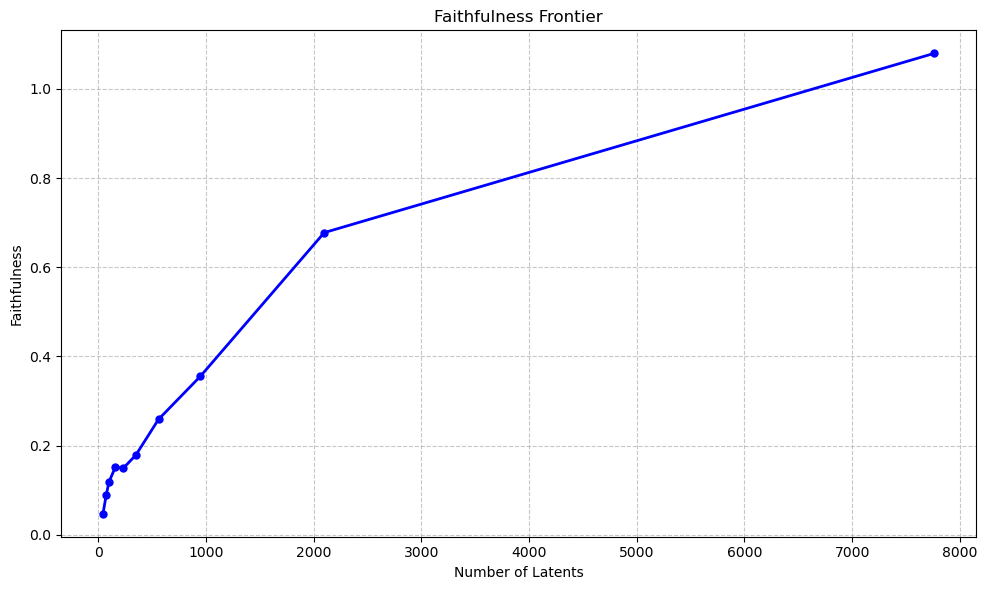

In [54]:

def plot_faithfulness_frontier(faithfulness_frontier):
    # Assuming faithfulness_frontier is your list of tuples
    # Example: faithfulness_frontier = [(10, 0.8), (20, 0.85), (30, 0.89), ...]

    # Unzip the tuples into separate lists for x and y coordinates
    num_latents, faithfulness = zip(*faithfulness_frontier)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_latents, faithfulness, 'b.-', linewidth=2, markersize=10)

    # Add labels and title
    plt.xlabel('Number of Latents')
    plt.ylabel('Faithfulness')
    plt.title('Faithfulness Frontier')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can customize the axis ranges if needed
    # plt.xlim([min(num_latents), max(num_latents)])
    # plt.ylim([min(faithfulness), max(faithfulness)])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_faithfulness_frontier(ig_faithfulness_frontier)

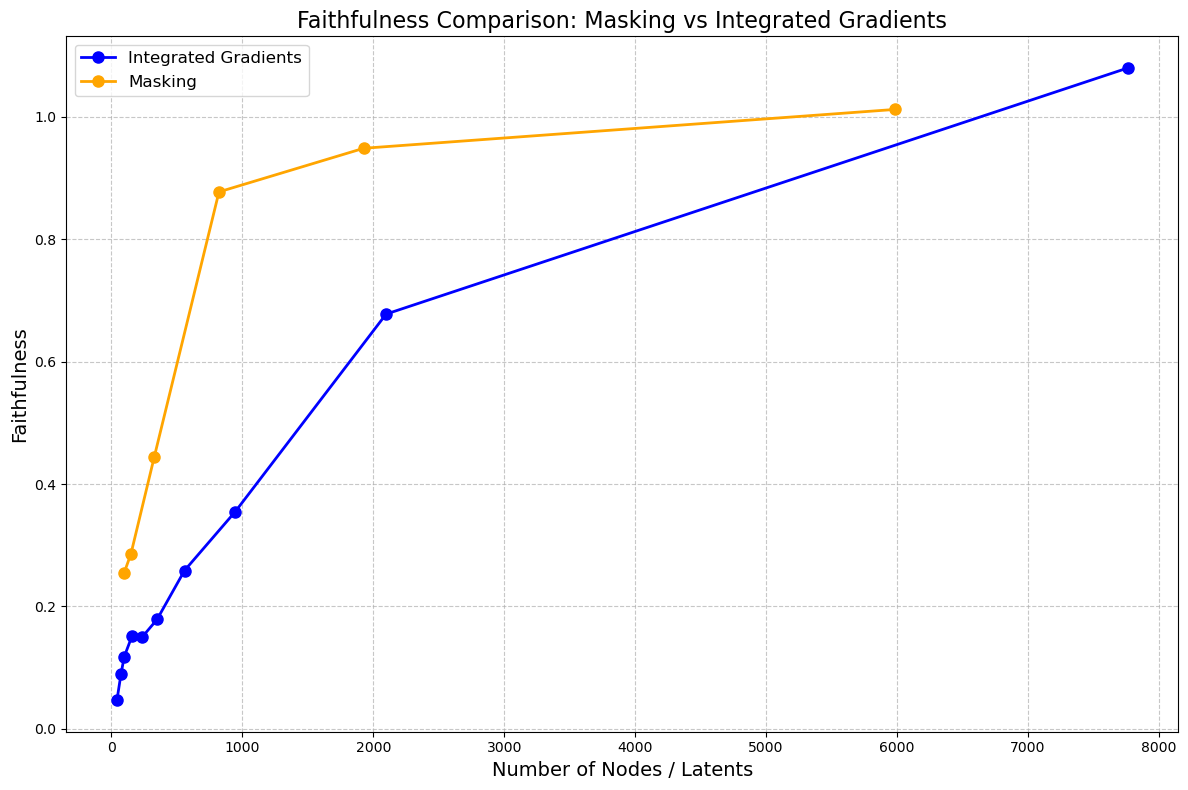

In [55]:
import matplotlib.pyplot as plt
import json
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.0001
end_threshold = 0.07
n_runs = 10
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
nnodes = []
faithfulness = []
for i in thresholds[:6]:
    sparsity_multiplier = i
    bdir = f"masks/ioi/baba21/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])


# Unzip the tuples into separate lists for Integrated Gradients plot
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents, ig_faithfulness, marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Masking', color='orange')

# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# data creation stuff

In [45]:
torch.abs(saes[0].mask.mask).sum() * saes[0].mask.distinct_l1

tensor(262144., device='cuda:0', grad_fn=<MulBackward0>)

In [65]:
torch.abs(saes[0].mask.mask).sum()

tensor(16384., device='cuda:0', grad_fn=<SumBackward0>)

In [66]:
saes[0].mask.temperature

tensor(1.)

In [70]:
torch.sigmoid(saes[0].mask.mask * saes[0].mask.temperature)

tensor([0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [41]:
saes[0].mask.sparsity_loss

tensor(191642.6094, device='cuda:0', grad_fn=<MulBackward0>)

In [40]:
torch.sum(saes[0].mask.mask == 1)

tensor(262144, device='cuda:0')

In [43]:
torch.sum(saes[0].mask.mask>0)

tensor(262144, device='cuda:0')

In [44]:
16056*16

256000

In [31]:
0.8*1.3

1.04

In [91]:
from data.ioi import ioi_dataset

ioi_data = ioi_dataset.IOIDataset(prompt_type="BABA",nb_templates=2, N = 6000)
abc_data = (
    ioi_data.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
    )

/home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/work/pi_jensen_umass_edu/jnainani_umass_edu/ScalableSAECircuits/data/ioi/ioi_dataset.py:634: UserWarning: S2 index has been computed as the same for S and S2
  warnings.warn("S2 index has been computed as the same for S and S2")


In [92]:
lower = 0
i = 0
for pr in ioi_data.ioi_prompts:
    ll = len(model.tokenizer.encode(pr['text']))
    # print(ll)
    # print(pr['text'])
    if ll == 21:
        lower += 1
    # i += 1
    # if i > 10:
    #     break
print(lower)

2966


In [94]:
import re
def truncate_to_end_with_to(text):
    return re.sub(r'\s+\S+$', '', text)

In [95]:
full_ioi_dataset = []
for ind, pr in enumerate(ioi_data.ioi_prompts):
    pr_abc = abc_data.ioi_prompts[ind]
    ll = len(model.tokenizer.encode(pr['text']))
    labv = len(model.tokenizer.encode(pr_abc['text']))
    if ll == 21 and ll == labv:
        ioi_dict = {"clean_prefix": truncate_to_end_with_to(pr['text']), "patch_prefix": truncate_to_end_with_to(pr_abc['text']), "clean_answer": ' '+pr['IO'], "patch_answer": ' '+pr['S'], "case": "BABA_21"}
        full_ioi_dataset.append(ioi_dict)

len(full_ioi_dataset)

2966

In [96]:
# save the ioi dataset
with open('data/ioi_train_21.json', 'w') as outfile:
    json.dump(full_ioi_dataset, outfile)

In [98]:
import json
file_path = 'data/ioi/ioi_train_21.json'
with open(file_path, 'r') as file:
    data = json.load(file)